# Identifying Threshold

Plotting SAD vs Window length
* Take the absolute difference curve. Smooth it out, and see what the absolute difference is.

##### Grab the CSV file you want to analyze

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter as sgf
from math import factorial as fact

df = pd.read_csv("../Scan CSV Files/10.csv")
df.drop("Unnamed: 0", axis = 1, inplace=True)
df.set_index("Wavelengths", inplace=True)
df.head()

,0,1.01,2.01,3.02,4.03,5.04,6.05,7.06,8.06,9.07,...,810.68,810.8,810.91,811.02,811.13,811.24,811.35,811.47,811.58,811.69
Wavelengths,,,,,,,,,,,,,,,,,,,,,
340.191309,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,...,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498
340.562061,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,...,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736
340.932784,770.6916,891.2760,880.7904,841.4694,825.7410,828.3624,791.6628,823.1196,857.1978,825.7410,...,773.3130,841.4694,810.0126,768.0702,888.6546,781.1772,815.2554,807.3912,825.7410,728.7492
341.303478,781.1772,762.8274,741.8562,762.8274,781.1772,807.3912,841.4694,810.0126,841.4694,867.6834,...,733.9920,752.3418,799.5270,783.7986,707.7780,744.4776,783.7986,802.1484,741.8562,833.6052
341.674143,686.8068,723.5064,728.7492,768.0702,770.6916,699.9138,812.6340,825.7410,728.7492,710.3994,...,707.7780,747.0990,699.9138,754.9632,791.6628,692.0496,731.3706,765.4488,715.6422,754.9632


### Calculating the threshold value for steady state

In [142]:
# Absolute difference between reference scans
diff = [] # List with the SAD

# Calculating the differences
first = list(df[df.columns[0]]) # Compare with first spectrum
for i in df.columns:
    compare = list(df[i])
    diff.append(sum([abs(i-j) for i,j in zip(first, compare)]))

# Calculates best window length for smoothing function
def N_opt(diff, L = len(diff), n=3):
    n = 3
    term1 = (2*(n+2) * (fact(2*n+3))**2)/(fact(n+1))**2

    vn = 1/L * sum(np.diff(diff,n+2)**2)
    var = np.var(diff)**2

    Nopt = (term1*var/vn)**(1/(2*n+5))
    
    return int(np.ceil(Nopt) // 2 * 2 + 1)

# Spectrum for calculating threshold
diff = sgf(diff, window_length=N_opt(diff), polyorder=3)

# gives the incremental difference between data points
change = [i - j for i,j in zip(diff[:-2], diff[1:])]
change = sgf(change, window_length=301, polyorder=3)
sec_deriv = sgf(change, window_length=101, polyorder=3, deriv=2)

# Finds steady state value, where value of second derivative stays within 0.2 over 60 time steps
def steady_state(seq, n=60, eps=0.2):
    seq = abs(seq) < eps
    for i in range(len(seq)):
        win = seq[i:i+n]
        if sum(win) == n:
            return int(i+n/2)
        
threshold = steady_state(sec_deriv)

In [143]:
threshold

30

### Plotting values

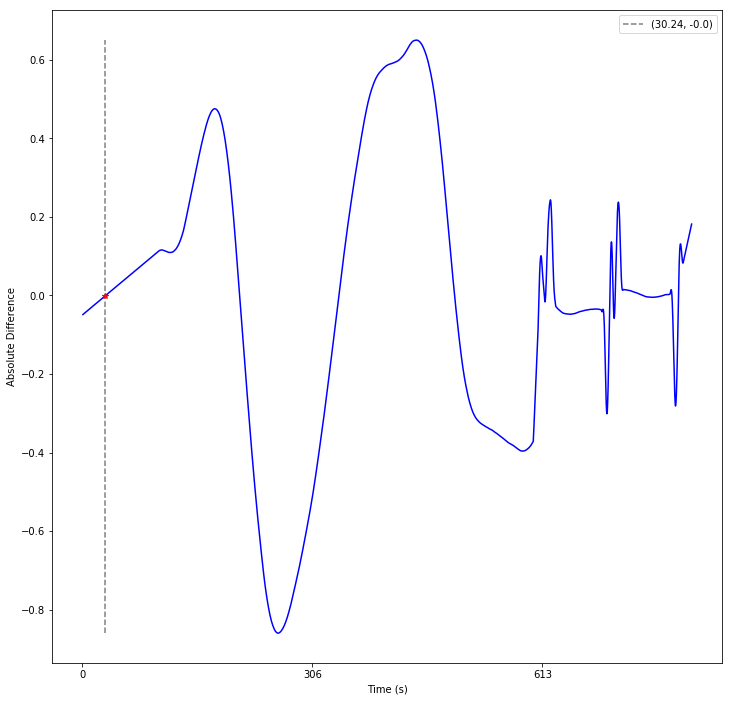

In [145]:
%matplotlib inline

curr_plot = sec_deriv

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, ylabel="Absolute Difference", xlabel="Time (s)")
ax.set_xticks([float(df.columns[i])*2 for i in range(len(df.columns)) if i%int(len(df.columns)/10) == 0])

dfcols = [float(i) for i in df.columns[1:threshold]] + [float(i) for i in df.columns[threshold+1:-1]]
ax.plot(dfcols, np.concatenate((curr_plot[:threshold], curr_plot[threshold+1:])), 'b-')
ax.plot(float(df.columns[threshold]), curr_plot[threshold], 'r*')

# plt.axvspan(0,float(df.columns[threshold]), color="y", alpha=0.2)
# plt.axhspan(min(curr_plot),curr_plot[threshold], color="b", alpha=0.2)
plt.vlines(float(df.columns[threshold]),min(curr_plot), max(curr_plot), alpha=0.5, linestyles={'dashed'}, label='{}'
           .format((float(df.columns[threshold]), round(curr_plot[threshold],2))))
plt.legend()